In [ ]:
%tensorflow_version 1.x

!git clone https://github.com/winonecheng/spinningup.git
%cd spinningup
!pip install -e .

In [ ]:
from datetime import datetime
import os
import random
import json

import numpy as np
import pandas as pd
import tensorflow as tf
import gym
from scipy.stats import betabinom
%matplotlib inline
import matplotlib.pyplot as plt

## Environment

In [ ]:
dir_path = '/content/drive/My Drive/data/'
state_filename = 'C_features.csv'
tolerable_filename='C_furnace_tolerable_power.csv'
appliance_name = 'Furnace'

In [ ]:
class Env(gym.Env):
    metadata = {'render.modes': []}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self, num_pseudo_action=5, alpha_random=1, weight=[1, 1]):
        super(Env, self).__init__()

        self.state_df = pd.read_csv(dir_path+state_filename, index_col="time")
        self.tolerable_df = pd.read_csv(dir_path+tolerable_filename, index_col="time")

        # action bound is not used in ppo
        self.action_space = gym.spaces.Box(low=np.array([-2.0]), high=np.array([2.0]))
        self.observation_space = gym.spaces.Box(low=-1, high=100, shape=(self.state_df.shape[1], ))

        self.alpha = alpha_random
        self.weight = weight

        self.name = appliance_name
        self.num_pseudo_action = num_pseudo_action
        self.pseudo_actions = num_pseudo_action
        self.steps = 0

        self.actions = []
        self.original_powers = []
        self.tolerable_powers = []
        self.rewards = []
        self.feedbacks = []

    def step(self, action):
        date = self.state_df.index[self.steps]
        original_power = self.state_df[self.name].loc[date]
        tolerable_power = self.tolerable_df[self.name].loc[date]

        # scale action
        _action = (action[0] - 2.5) * 0.05
        controlled_power = original_power + _action
        
        feedback = 0
        if controlled_power < tolerable_power:
            if self.pseudo_actions == self.num_pseudo_action:
                # generate one random number with beta distribution
                random = betabinom.rvs(80, self.alpha, 3, size=1)[0] + 10 # range: [10,90]
                feedback = abs(original_power - tolerable_power) * random * 0.01
                self.tolerable_df[self.name].loc[date] = tolerable_power + feedback

            # comfort
            reward = controlled_power - (tolerable_power + feedback)
            reward *= self.weight[0]
            
        else:
            # energy saving
            reward = original_power - controlled_power
            reward *= self.weight[1]
        
        reward *= 10

        if self.pseudo_actions > 0:
            self.pseudo_actions -= 1
        else:
            self.steps += 1
            self.pseudo_actions = self.num_pseudo_action

        # store useful info
        self.actions.append(_action)
        self.original_powers.append(original_power)
        self.tolerable_powers.append(tolerable_power)
        self.rewards.append(reward)
        self.feedbacks.append(feedback)

        observation = self.state_df.iloc[self.steps].values

        return observation, reward, False, {'action': _action, 'original_power': original_power, 'controlled_power': controlled_power, 'tolerable_power': tolerable_power, 'feedback': feedback}

    def reset(self):
        observation = self.state_df.iloc[self.steps].values
        return observation

    def close(self):
        self.steps = 0
        self.pseudo_actions = self.num_pseudo_action

In [ ]:
EPISODE_LENGTH = 50
RETRAINS = 10
STEPS = EPISODE_LENGTH * (RETRAINS+1)
F_EPOCHS = 40573 * (RETRAINS+1) // STEPS
C_EPOCHS = 29235 * (RETRAINS+1) // STEPS
EPOCHS = C_EPOCHS

ALPHA = 1 # Beta(alpha, 3)
WEIGHT = [1, 1] # [comfort, energy]

env = Env(num_pseudo_action=RETRAINS, alpha_random=ALPHA, weight=WEIGHT)
env.seed(1)
env_fn = lambda: env

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# environment testing

# env.close()
# n_steps = 100
# for _ in range(n_steps):
#     # Random action
#     action = env.action_space.sample()

#     print(action)
#     # print(env.steps, env.retrains)

#     obs, reward, done, info = env.step(action)
#     print(done)

#     print(info)
#     print('---')

# Training

In [ ]:
from spinup import ppo_tf1

ac_kwargs = dict(hidden_sizes=[32, 64], activation=tf.nn.relu)
output_dir=f'/content/drive/My Drive/output/C_el{EPISODE_LENGTH}_s{STEPS}_e{EPOCHS}_pa{RETRAINS}_r{ALPHA}_w{WEIGHT}'
logger_kwargs = dict(output_dir=output_dir, exp_name='ppo')

In [ ]:
ppo_tf1(env_fn=env_fn, ac_kwargs=ac_kwargs, logger_kwargs=logger_kwargs,
        steps_per_epoch=STEPS, epochs=EPOCHS, max_ep_len=RETRAINS+1,
        train_pi_iters=45, train_v_iters=45, lam=1.0, gamma=1.0, target_kl=0.05, seed=1,
        pi_lr=0.0005, vf_lr=0.003)

Streaming output truncated to the last 5000 lines.
|      AverageVVals |             627 |
|          StdVVals |            18.9 |
|          MaxVVals |             660 |
|          MinVVals |             580 |
| TotalEnvInteracts |        1.99e+05 |
|            LossPi |       -3.86e-08 |
|             LossV |             165 |
|       DeltaLossPi |        -0.00795 |
|        DeltaLossV |           -66.1 |
|           Entropy |           -1.73 |
|                KL |          0.0405 |
|          ClipFrac |           0.304 |
|          StopIter |              21 |
|              Time |             597 |
---------------------------------------
---------------------------------------
|             Epoch |             361 |
|      AverageEpRet |           -3.48 |
|          StdEpRet |            11.5 |
|          MaxEpRet |              18 |
|          MinEpRet |             -23 |
|             EpLen |              11 |
|      AverageVVals |             621 |
|          StdVVals |        

# Visualization

In [ ]:
pd.Series(env.actions).describe()

count    321200.000000
mean         -0.111518
std           0.035977
min          -0.281178
25%          -0.135051
50%          -0.111417
75%          -0.087594
max           0.010240
dtype: float64

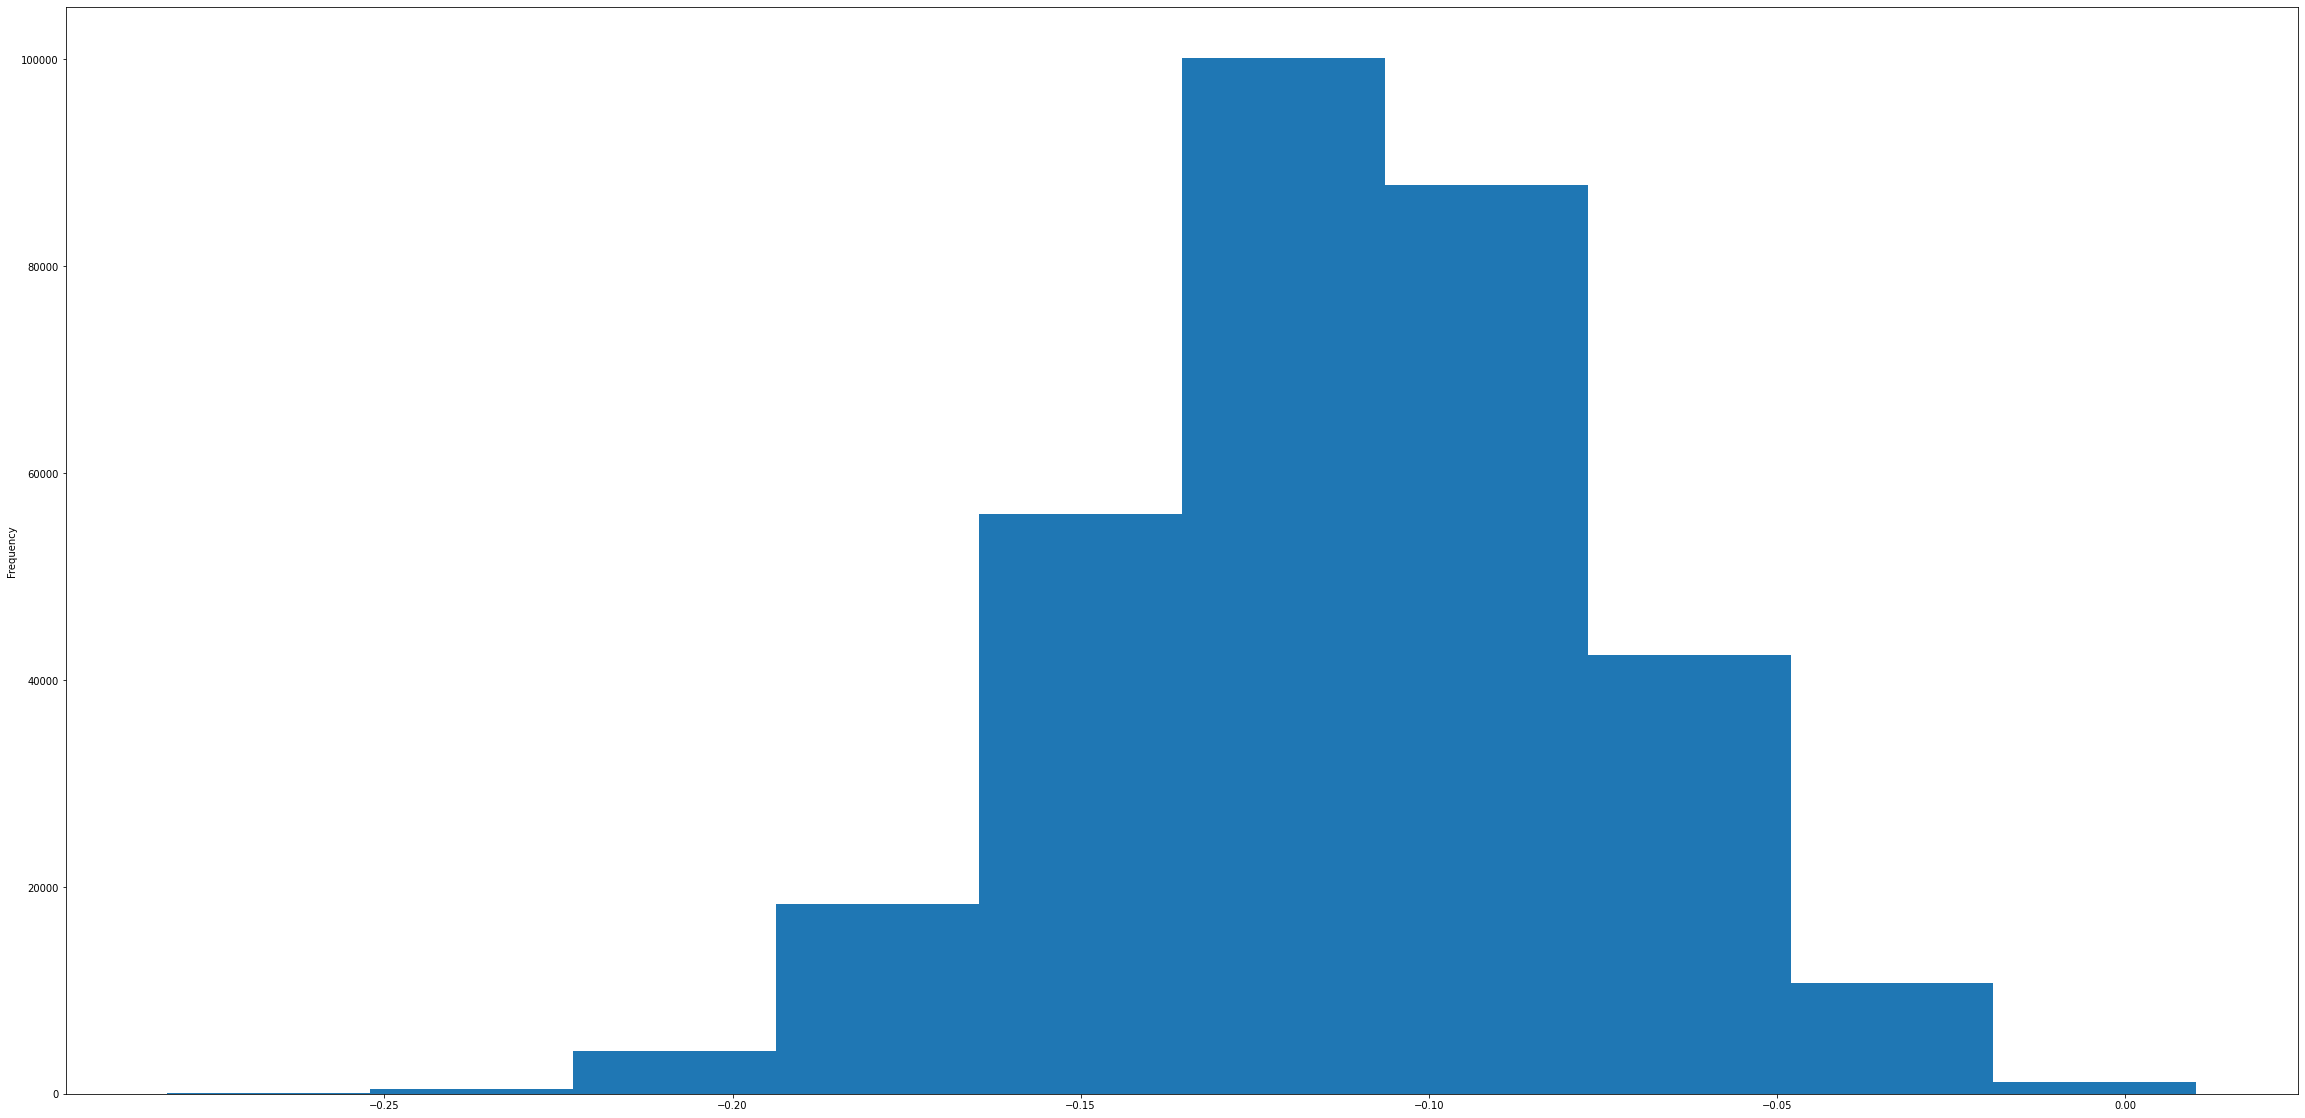

In [ ]:
pd.Series(env.actions).plot(kind='hist', figsize=(40,20))

In [ ]:
pd.Series(env.feedbacks).describe()

count    321200.000000
mean          0.000501
std           0.004159
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.139114
dtype: float64

In [ ]:
pd.Series(env.rewards).describe()

count    321200.000000
mean          0.507520
std           1.040100
min          -4.853855
25%          -0.350178
50%           0.875931
75%           1.247545
max           2.811779
dtype: float64

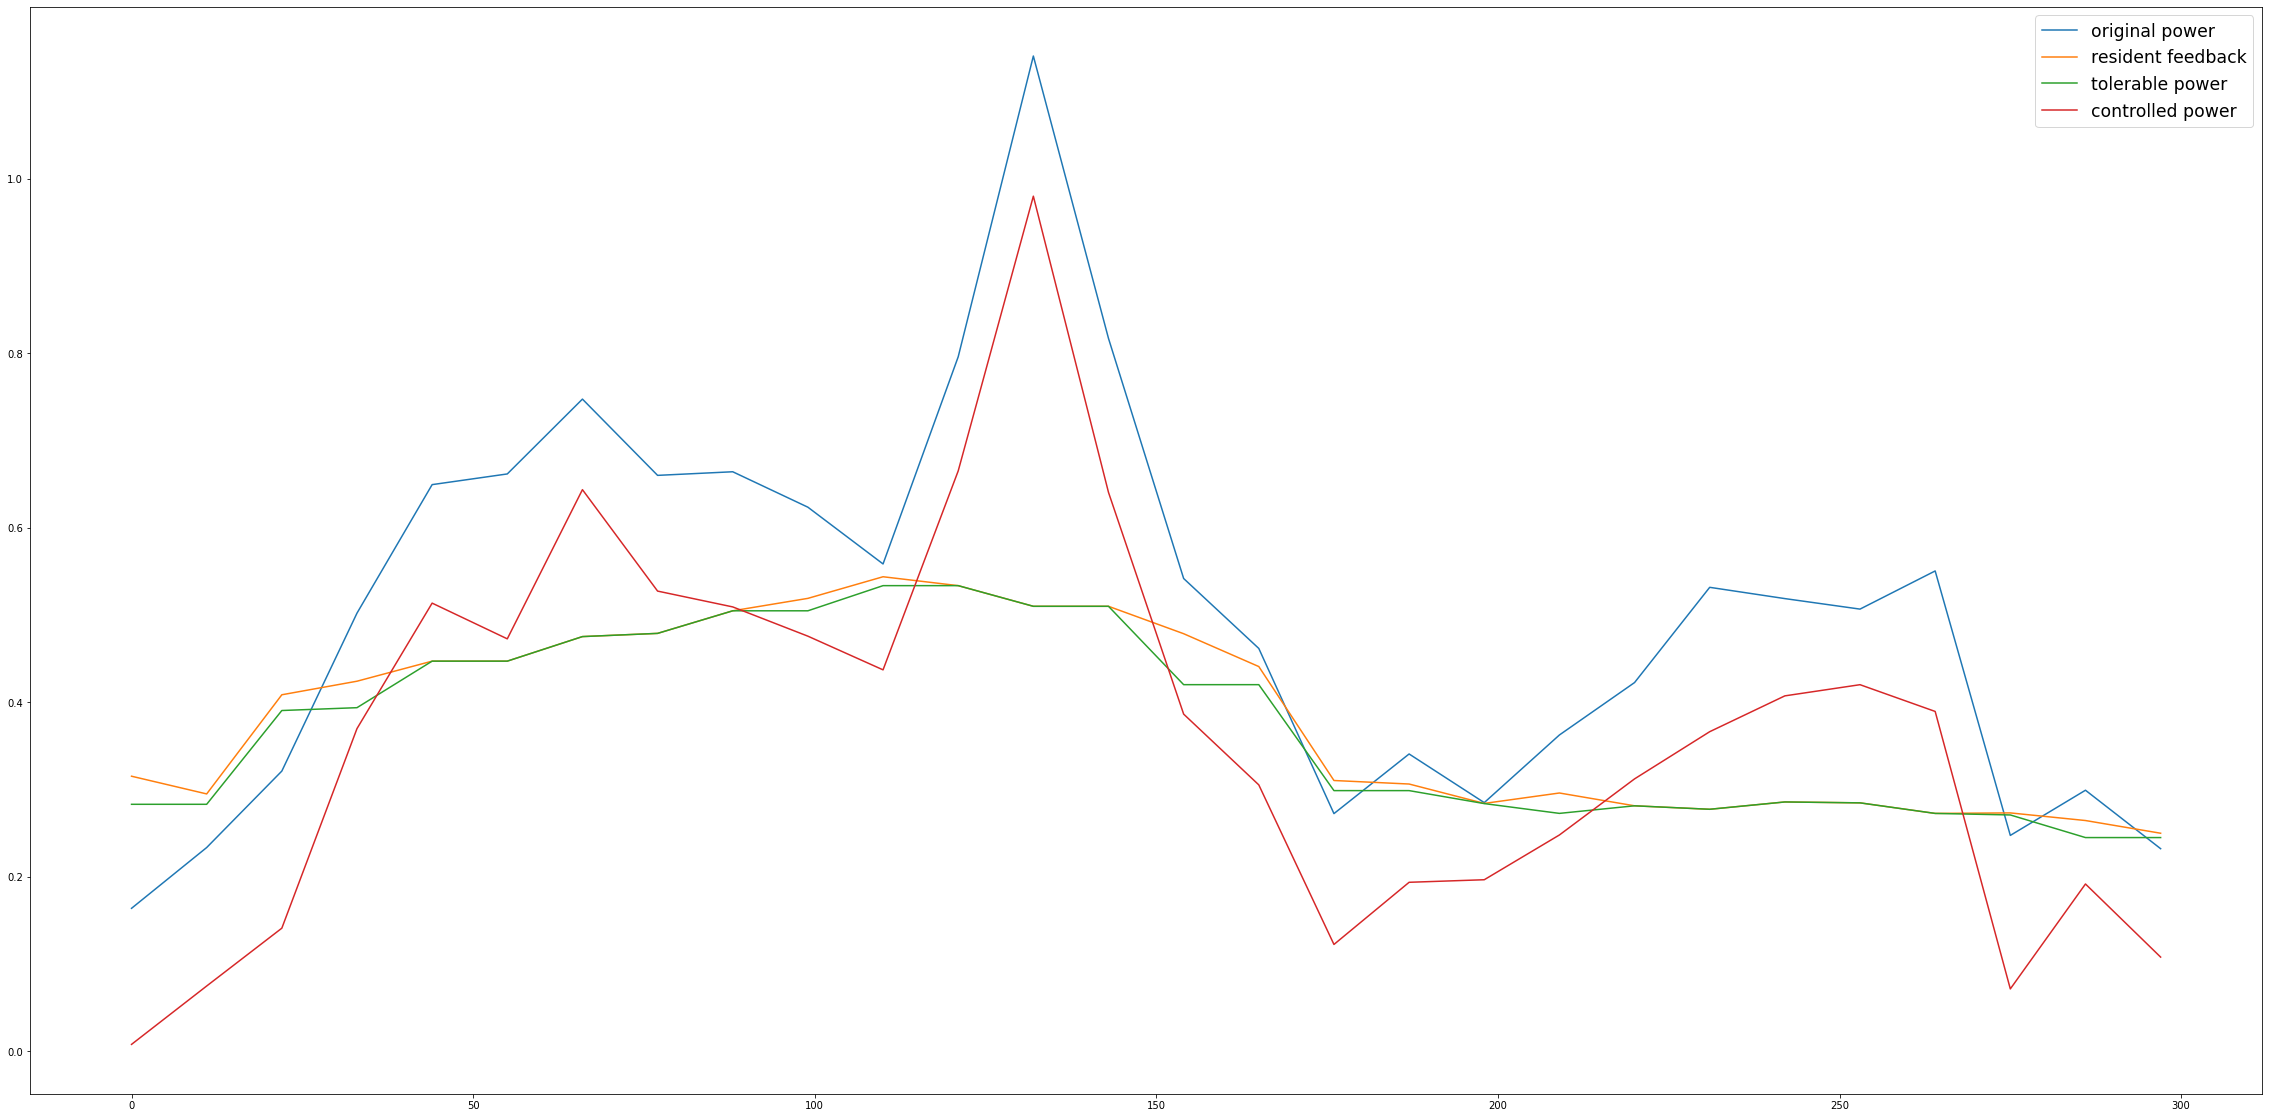

In [ ]:
plt.figure(figsize=(40,20))
plt.plot(pd.Series(env.original_powers).iloc[:300:RETRAINS+1])
plt.plot(pd.Series(np.add(env.tolerable_powers, env.feedbacks)).iloc[:300:RETRAINS+1])
plt.plot(pd.Series(env.tolerable_powers).iloc[:300:RETRAINS+1])
plt.plot(pd.Series(np.add(env.original_powers, env.actions)).iloc[:300:RETRAINS+1])

plt.legend(['original power', 'resident feedback', 'tolerable power', 'controlled power'], fontsize='xx-large')
plt.show()

# Store result

In [ ]:
import pickle

with open(f'{output_dir}/info.pkl', 'wb+') as f:
    pickle.dump({
        'actions': env.actions,
        'original_powers': env.original_powers,
        'tolerable_powers': env.tolerable_powers,
        'feedbacks': env.feedbacks,
        'rewards': env.rewards
    }, f)

In [ ]:
!ls '{output_dir}'

config.json  info.pkl  progress.txt  tf1_save  vars.pkl
